In [1]:
from model_phantom_DB import *
from linares_plot import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

For all the matrice data : each row is one trial, each column is one neuron. 
For the same row the trial data may not be collected on the same trial since data might are collected on different days.

cuerate: firing rate during 1st visual stimuli(cue) presentation.

cuerate_stim: firing rate during 1st cue presentation with NB stimulation. 

cdrate: firing rate during the 1st delay after 1st cue presentation. 

cdrate_stim: firing rate during the 1st delay after cue presentation  with NB stimulation.  
 
samplerate: firing rate during 2nd visual stimuli(sample) presentation. 

samplerate_stim: firing rate during sample presentation with NB stimulation. 

sdrate: firing rate during the delay after sample presentation. 

sdrate_stim: firing rate during the delay after sample presentation with NB stimulation. 

g1: location of 1st visual stimuli(cue)
 value -1 means no visual stimuli presented.
 value [1 2 3 4 5] are  relative locaions, such as [0 45 90 135 180], or [ 45 90 135 180 225], etc.
 The real locations depended on neurons' receptive field.
 According to our behavioral paradigm, the cue will only be presented on locaion [1 5]. that is two opposite locations, such as [0 180], [45 225], etc.
 For each neuron, thoes value([1:5]) refer to the same locations.

g2: location of 2nd visual stimuli(sample)
  Sample can show up in all five possible locations([1:5]) or not presented(-1).

g3: task type for each trial, eg. saccade to 1st (value 1), or saccade to 2nd(value 2).


In [21]:
from scipy.io import loadmat 
file = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Classifiy_data_odrdistvar_allNeurons_reverse.matlab'
data = loadmat(file)
data.keys()

dict_keys(['__version__', 'cdrate_stim', 'cdrate', '__globals__', 'cuerate', 'g3', 'sdrate_stim', 'cuerate_stim', 'g2_stim', '__header__', 'samplerate_stim', 'g3_stim', 'g1', 'sdrate', 'samplerate', 'g2', 'g1_stim'])

In [22]:
rate_d1_off = data['cdrate']
positions_stim_off= data['g1'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

rate_d1_on = data['cdrate_stim']
positions_stim_on= data['g1_stim'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

In [32]:
number_neurons = np.shape(rate_d1_off)[1]

In [26]:
### neuron 1 off
Neuron = 0

n1_rates = rate_d1_off[:,Neuron]
n1_positions = positions_stim_off[:,Neuron]

#just get the 1 and 5 (RF and oppoiste)
n1_y = n1_positions[n1_positions>0]
n1_x = n1_rates[n1_positions>0]


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [27]:
y_off = label_binarize(n1_y, classes=[5,1]) #matrix (1,0,0,...,0)
n_classes = y_off.shape[1]
X_off =np.reshape(n1_x, (len(n1_x),1))

In [42]:
number_neurons = np.shape(rate_d1_off)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='OFF'
reps_ = 100 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []


for Neuron in range(number_neurons):
    print(Neuron)
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_off.append(fpr["macro"])
        tpr_mean_off.append(tpr["macro"])
        roc_mean_off.append(roc_auc["macro"])
    ###
    ###
    ###

    
    

0


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


1


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


2


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


3


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


4


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


5


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


6


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


7
8


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


10


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


11
12


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


13


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


14
15


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


16
17


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


18


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


19


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


20


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


21


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


22
23


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


24


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


25


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


26
27


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


28
29


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


30


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


31
32


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


33
34

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater



35


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


36


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


37


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


38


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


39


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


40


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


41


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


42
43


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


44


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


45


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


46


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


47


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


48


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


50


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


51


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


52


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


53


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


54


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

55
56


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

57


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


58
59


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


60


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


61


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


62


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


63


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


64


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


65
66


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


67


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


68


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


69


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


70


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

71
72


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


73


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


74


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


75


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


76


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

77


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

78


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

79


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


80


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


81


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


82


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


83


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


84


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


85


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


86


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


87


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


88


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


89


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


90


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


91
92


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


93


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


94


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


95


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


96


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


97


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


98


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


99


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


100


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

101
102


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


103


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


104


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


105


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


106


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


107


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


108


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


109


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


110


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


111


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


112


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


113
114


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


115
116


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


117
118


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


119
120


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


121
122


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


123
124


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


125
126


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


127
128


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


129


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


130


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


131


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


132
133


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


134


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


135


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


136
137


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


138


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

139
140


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


141


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


142


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


143
144


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


145


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


146


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


147


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


148


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


149


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


150


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


151


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


152


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


153


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


154
155


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


156


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

157
158


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


159


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


160


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


161


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


162


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


163


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


164


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


165


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


166


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

167
168


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


169


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


170
171
172


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


173


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


174


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


175


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

176
177
178


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


179


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


180
181


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


182
183


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


184
185


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


186
187


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


188


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


189


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


190


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


191


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


192


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


193
194


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


195
196


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


197
198


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


199


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % sel

200
201


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMa

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

202
203


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


204
205


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


206
207


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


208


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


209


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


210


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


211


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


212


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


213


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


214
215


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


216
217


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


218


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


219


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


220


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


221


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


222


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


223
224


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


225


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


226


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


227


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


228


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


229


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


230
231


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


232


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


In [ ]:
number_neurons = np.shape(rate_d1_off)[1]
#### I am, doing this for OFF, later I will do it for ON

stimulation='OFF'
reps_ = 100 ### reps in each neuron (train and test)

##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

### place to append the outcomes of repetitions (cross validated measure extracted from this)
fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []


for Neuron in range(number_neurons):
    print(Neuron)
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    n_classes = y.shape[1]
    X =np.reshape(nx_x, (len(nx_x),1))
    ###
    ###
    for rep in range(reps_): ### cross validation with reps train and test
        ##print(Neuron, rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        ######
        ######
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        fpr_mean_on.append(fpr["macro"])
        tpr_mean_on.append(tpr["macro"])
        roc_mean_on.append(roc_auc["macro"])
    ###
    ###
    ###

    

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


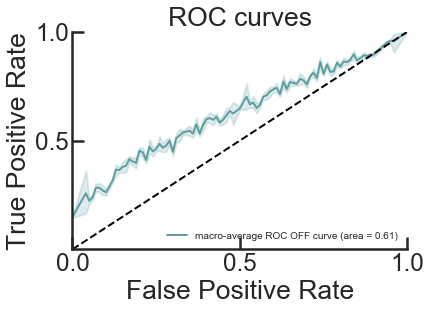

In [43]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



# fpr_mean_on = np.concatenate(fpr_mean_on)
# tpr_mean_on = np.concatenate(tpr_mean_on)
# df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
# df_ROC_ON = df_ROC_ON.round(2)


# sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
#              linestyle='--', linewidth=2, 
#              label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

#scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [ ]:
reps_ = 2
##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []

for rep in range(reps_):
    print(stimulation, rep)
    ## split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
    X_train =np.reshape(X_train, (len(X_train),1))
    X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])

